In [3]:
import fancyimpute
import imblearn
import joblib
import matplotlib as plt
import numpy as np
import pandas as pd
import scikit_learn as sklearn
import scipy
import seaborn
import six
import xgboost

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from fancyimpute import KNN, SoftImpute

In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import LabelBinarizer,StandardScaler,OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression,RidgeClassifier, PassiveAggressiveClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import joblib

%matplotlib inline


In [7]:
import operator

In [8]:
import six
import sys
sys.modules['sklearn.externals.six'] = six

In [9]:
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base

In [10]:
from sklearn.utils import _safe_indexing
sys.modules['sklearn.utils.safe_indexing'] = sklearn.utils._safe_indexing

In [11]:
from imblearn.over_sampling import SMOTE

In [12]:

def classify(est, x, y,X_test,y_test):
    #Passing the model and train test dataset to fit the model
    est.fit(x, y)
    #Predicting the probabilities of the Tet data
    y2 = est.predict_proba(X_test)
    y1 = est.predict(X_test)

    print("Accuracy: ", metrics.accuracy_score(y_test, y1))
    print("Area under the ROC curve: ", metrics.roc_auc_score(y_test, y2[:, 1]))
    #Calculate different metrics
    print("F-metric: ", metrics.f1_score(y_test, y1))
    print(" ")
    print("Classification report:")
    print(metrics.classification_report(y_test, y1))
    print(" ")
    print("Evaluation by cross-validation:")
    print(cross_val_score(est, x, y))

    return est, y1, y2[:, 1]


#Function to find which features are more important than others through model
def feat_importance(estimator):
    feature_importance = {}
    for index, name in enumerate(df_LC.columns):
        feature_importance[name] = estimator.feature_importances_[index]

    feature_importance = {k: v for k, v in feature_importance.items()}
    sorted_x = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse = True)

    return sorted_x

#Model to  predict the ROC curve for various models and finding the best one
def run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced'):

    clfs = {'GradientBoosting': GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3),
            'LogisticRegression' : LogisticRegression(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=10),
            'XGBClassifier': XGBClassifier()
            }
    cols = ['model','matthews_corrcoef', 'roc_auc_score', 'precision_score', 'recall_score','f1_score']

    models_report = pd.DataFrame(columns = cols)
    conf_matrix = dict()

    for clf, clf_name in zip(clfs.values(), clfs.keys()):

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        y_score = clf.predict_proba(X_test)[:,1]

        print('computing {} - {} '.format(clf_name, model_type))

        tmp = pd.Series({'model_type': model_type,
                         'model': clf_name,
                         'roc_auc_score' : metrics.roc_auc_score(y_test, y_score),
                         'matthews_corrcoef': metrics.matthews_corrcoef(y_test, y_pred),
                         'precision_score': metrics.precision_score(y_test, y_pred),
                         'recall_score': metrics.recall_score(y_test, y_pred),
                         'f1_score': metrics.f1_score(y_test, y_pred)})

        models_report = models_report.append(tmp, ignore_index = True)
        conf_matrix[clf_name] = pd.crosstab(y_test, y_pred, rownames=['True'], colnames= ['Predicted'], margins=False)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score, drop_intermediate = False, pos_label = 1)

        plt.figure(1, figsize=(6,6))
        plt.xlabel('false positive rate')
        plt.ylabel('true positive rate')
        plt.title('ROC curve - {}'.format(model_type))
        plt.plot(fpr, tpr, label = clf_name )
        plt.legend(loc=2, prop={'size':11})
    plt.plot([0,1],[0,1], color = 'black')

    return models_report, conf_matrix

In [13]:
#Importing the datasets
import pandas as pd
data =pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/358/LoansTrainingSetV2.csv")

In [14]:
data.head()
len(data)

111107

In [15]:
data

,Loan ID,Customer ID,Loan Status,Current Loan Amount,Term,Credit Score,Years in current job,Home Ownership,Annual Income,Purpose,Monthly Debt,Years of Credit History,Months since last delinquent,Number of Open Accounts,Number of Credit Problems,Current Credit Balance,Maximum Open Credit,Bankruptcies,Tax Liens
0,6cf51492-02a2-423e-b93d-676f05b9ad53,7c202b37-2add-44e8-9aea-d5b119aea935,Loan Refused,12232,Short Term,7280.0,< 1 year,Rent,46643.0,Debt Consolidation,777.39,18.0,10.0,12,0,6762,7946,0.0,0.0
1,552e7ade-4292-4354-9ff9-c48031697d72,e7217b0a-07ac-47dd-b379-577b5a35b7c6,Loan Refused,25014,Long Term,7330.0,10+ years,Home Mortgage,81099.0,Debt Consolidation,892.09,26.7,NaN,14,0,35706,77961,0.0,0.0
2,9b5e32b3-8d76-4801-afc8-d729d5a2e6b9,0a62fc41-16c8-40b5-92ff-9e4b763ce714,Loan Refused,16117,Short Term,7240.0,9 years,Home Mortgage,60438.0,Home Improvements,1244.02,16.7,32.0,11,1,11275,14815,1.0,0.0
3,5419b7c7-ac11-4be2-a8a7-b131fb6d6dbe,30f36c59-5182-4482-8bbb-5b736849ae43,Loan Refused,11716,Short Term,7400.0,3 years,Rent,34171.0,Debt Consolidation,990.94,10.0,NaN,21,0,7009,43533,0.0,0.0
4,1450910f-9495-4fc9-afaf-9bdf4b9821df,70c26012-bba5-42c0-8dcb-75295ada31bb,Loan Refused,9789,Long Term,6860.0,10+ years,Home Mortgage,47003.0,Home Improvements,503.71,16.7,25.0,13,1,16913,19553,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111102,503f01e2-c3c4-4b10-886e-f15de57b6f1a,27a17610-1d8c-48a7-b0db-2d81a4fa099a,Loan Given,15654,Long Term,686.0,10+ years,Rent,43050.0,Debt Consolidation,889.69,14.1,49.0,18,0,14730,29757,0.0,0.0
111103,8af53bc0-56a4-4801-a960-52a46a90b33f,c124ca71-f42a-47cc-8ec2-236f7e9868a5,Loan Given,15237,Short Term,706.0,10+ years,Home Mortgage,60948.0,Debt Consolidation,700.9,15.9,48.0,11,0,17733,23060,0.0,0.0
111104,96efd327-f965-42ae-8b2b-d2555205ce19,7d959a54-8eeb-4df6-b582-046f889e4cff,Loan Given,10413,Short Term,719.0,5 years,Home Mortgage,66945.0,Debt Consolidation,1210.59,8.7,NaN,11,0,5205,6348,0.0,0.0
111105,ec19166c-70c5-4d49-adb6-fb3fc15024a2,5723fbf2-1ce8-4752-8bee-1bebf339f278,Loan Given,34447,Short Term,626.0,10+ years,Home Mortgage,78736.0,Debt Consolidation,1476.3,30.4,9.0,12,0,32318,37580,0.0,0.0


In [16]:
##Drop the duplicates with respect to LOAN ID
data.drop_duplicates(subset="Loan ID",keep='first',inplace=True)

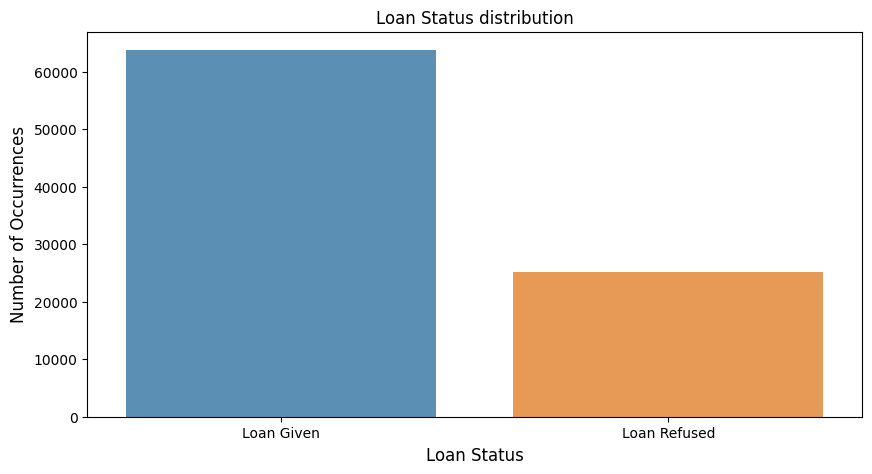

In [17]:
##########Plotting the loan status
status=data["Loan Status"].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Status distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan Status', fontsize=12)
plt.show()

In [18]:
#Finding IQR's for outlier removal

Q1 = data["Current Loan Amount"].quantile(0.25)
Q3 = data["Current Loan Amount"].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

16202.0


In [19]:
data["Current Loan Amount"][((data["Current Loan Amount"] < (Q1 - 1.5 * IQR)) |(data["Current Loan Amount"] > (Q3 + 1.5 * IQR)))]

,Current Loan Amount
5044,99999999
5045,99999999
5046,99999999
5047,99999999
5048,99999999
...,...
17777,99999999
17778,99999999
17779,99999999
17780,99999999


In [20]:
# Replace > 9999998 with NAN values
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount_temp"] = np.where(temp > 9999998, 'NaN', temp).tolist()

,Current Loan Amount_temp
count,76172.000000
mean,13933.915756
std,8235.921922
min,491.000000
25%,7810.000000
50%,12038.000000
75%,19351.000000
max,35875.000000


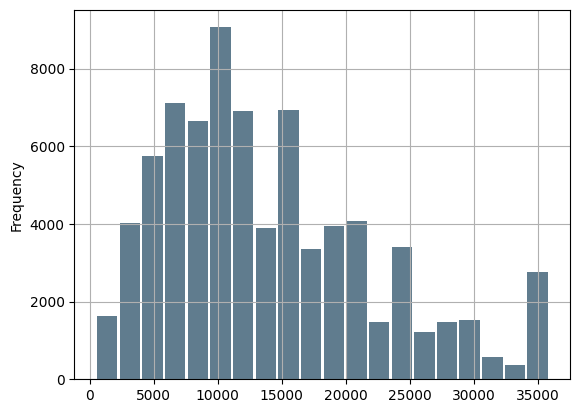

In [21]:
temp=data["Current Loan Amount_temp"][data["Current Loan Amount_temp"]!='NaN'].astype(str).astype(int)
temp.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')

temp.describe()


In [22]:
#Replacing the data with 50% percentile or mean
temp=np.array(data["Current Loan Amount"].values.tolist())
data["Current Loan Amount"] = np.where(temp > 9999998,12038,temp).tolist()

data=data.drop(['Current Loan Amount_temp'],axis=1)

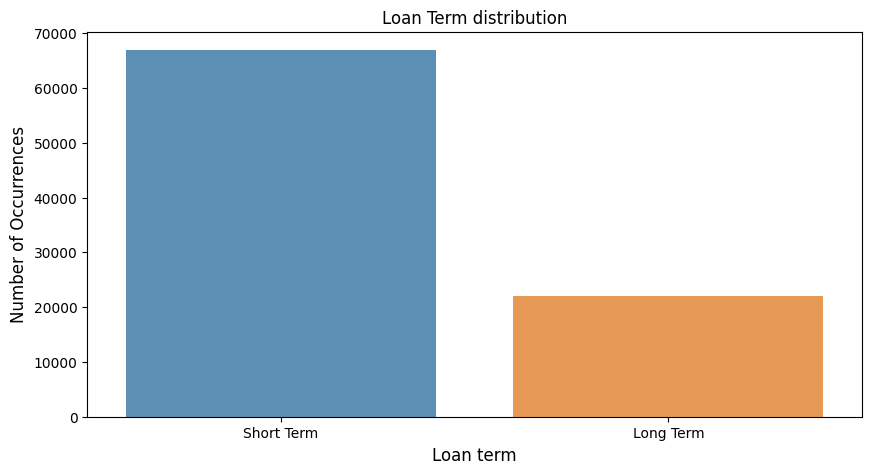

In [23]:

############Term ##############

status=data["Term"].value_counts()

plt.figure(figsize=(10,5))
sns.barplot(x=status.index, y=status.values, alpha=0.8)
plt.title('Loan Term distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Loan term', fontsize=12)
plt.show()


In [24]:
#####Credit Score#############

##Max is 7510. It should be between 0-800

data["Credit Score"].describe()

,Credit Score
count,67572.000000
mean,1199.199580
std,1680.813805
min,585.000000
25%,714.000000
50%,733.000000
75%,744.000000
max,7510.000000


<Axes: xlabel='Credit Score'>

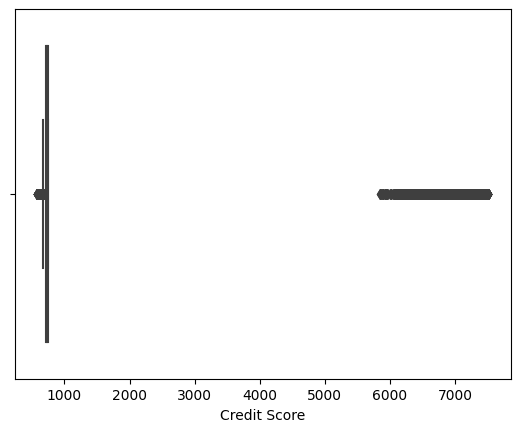

In [25]:

sns.boxplot(x=data["Credit Score"])

In [26]:
data["Credit Score"].isnull().sum()


21338

In [27]:
# Dividing the values greater than 800 by 10

data["Credit Score"]=np.where(data["Credit Score"]>800, data["Credit Score"]/10, data["Credit Score"])


<Axes: xlabel='Credit Score_1', ylabel='Density'>

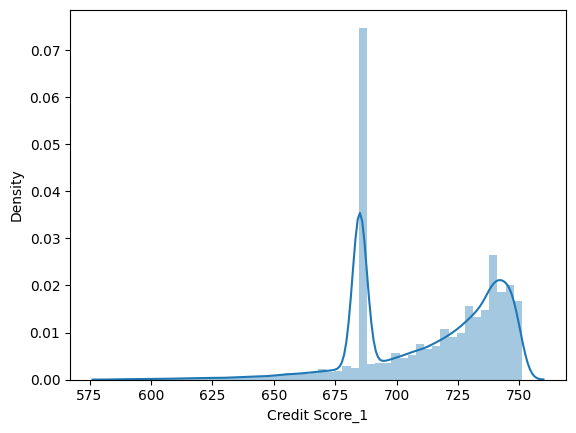

In [28]:
# Replacing the missing values with median
median_score=statistics.median(data["Credit Score"])

data["Credit Score_1"]=data["Credit Score"]
data["Credit Score_1"].fillna(median_score, inplace = True)

sns.distplot(data["Credit Score_1"])


<Axes: xlabel='Credit Score', ylabel='Density'>

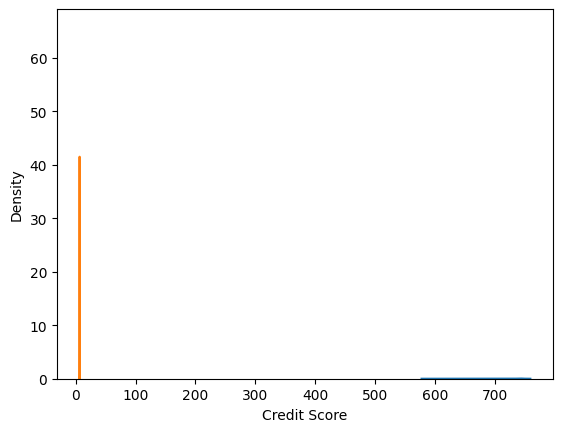

In [29]:
#As the data is skewed, replacing it with median is giving problems.
#Replacing with 75th percentile and taking log will give a better distribution


data["Credit Score"].fillna(741, inplace = True)

sns.distplot(data["Credit Score"])
sns.distplot(np.log(data["Credit Score"]))

In [30]:
data['Home Ownership'].unique()
#It has Home Mortgage and haveMortgage as 2 different classes.

array(['Rent', 'Home Mortgage', 'Own Home', 'HaveMortgage'], dtype=object)

In [31]:
data['Home Ownership']=data['Home Ownership'].str.replace('HaveMortgage', 'Home Mortgage', regex=True)

data['Home Ownership'].unique()


array(['Rent', 'Home Mortgage', 'Own Home'], dtype=object)

In [32]:
##################Annual Income######################
data['Annual Income'].describe()


,Annual Income
count,6.757200e+04
mean,7.234575e+04
std,5.836101e+04
min,4.033000e+03
25%,4.458600e+04
50%,6.149400e+04
75%,8.675025e+04
max,8.713547e+06


In [33]:
## Quantiles of this columns

data['Annual Income'].quantile([.2,0.75,0.90,.95,0.99,.999])


,Annual Income
0.200,40764.00
0.750,86750.25
0.900,119916.00
0.950,147645.00
0.990,239286.96
0.999,491575.77


In [34]:
# Capping any values greater than 99% to 99th value
data.loc[data['Annual Income'] > 239287, 'Annual Income'] = 239287


data['Annual Income'].isna().sum()


21338

In [35]:
###############Loan Purpose ###############

data['Purpose'].value_counts()
# 'other' and 'Other' mean the same thing.

,Purpose
Debt Consolidation,70447
Home Improvements,5206
other,4917
Other,2850
Business Loan,1328
Buy a Car,1196
Medical Bills,955
Buy House,559
Take a Trip,454
major_purchase,344


In [36]:
data['Purpose']=data['Purpose'].str.replace('Other', 'other', regex=True)

In [37]:
#######Monthly debt ###############


data['Monthly Debt'].describe()
##This is not numeric column.


,Monthly Debt
count,88910
unique,76609
top,0
freq,55


In [38]:
data['Monthly Debt']
# But this should be a numeric column. Converting it to float


,Monthly Debt
0,777.39
1,892.09
2,1244.02
3,990.94
4,503.71
...,...
88905,567.62
88906,2508.63
88907,818.2
88908,360.17


In [40]:
data['Monthly Debt'].unique()

array(['777.39', '892.09', '1244.02', ..., 2508.63, 818.2, 360.17],
      dtype=object)

In [41]:
data['Monthly Debt']=data['Monthly Debt'].str.replace('$', '')


<Axes: xlabel='Monthly Debt', ylabel='Density'>

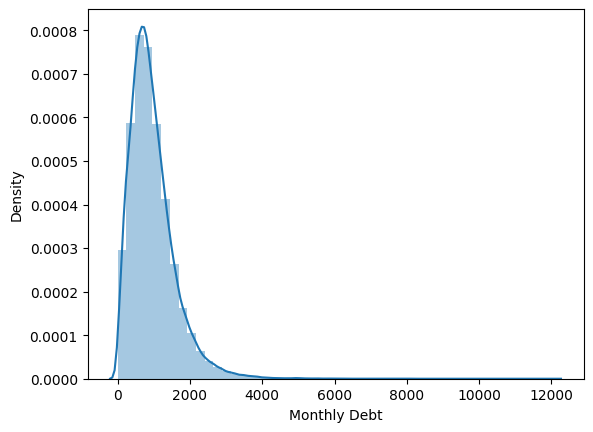

In [42]:
data['Monthly Debt']=pd.to_numeric(data['Monthly Debt'] )

sns.distplot(data["Monthly Debt"])

In [43]:
#There are outliers in this data

data['Monthly Debt'].describe()
#The max value is too high here


,Monthly Debt
count,65536.000000
mean,962.406632
std,632.799593
min,0.000000
25%,532.250000
50%,843.770000
75%,1251.342500
max,12055.680000


In [44]:
data['Monthly Debt'].quantile([.2,0.75,0.90,.95,0.99,.999])


,Monthly Debt
0.200,464.21000
0.750,1251.34250
0.900,1740.35000
0.950,2112.21000
0.990,3084.08600
0.999,4927.21625


In [45]:
#Problem is with 99th percentile.

data['Monthly Debt'].quantile([0.9995,.9999])


,Monthly Debt
0.9995,5513.352425
0.9999,7719.187600


In [46]:
data['Monthly Debt'].quantile([0.9997,.99999])
#0.99970     5978.574911
#0.99999    13262.762330


,Monthly Debt
0.99970,5979.063765
0.99999,11253.511940


In [47]:
data['Monthly Debt'].quantile([0.999,1])


,Monthly Debt
0.999,4927.21625
1.000,12055.68000


<Axes: xlabel='Monthly Debt', ylabel='Density'>

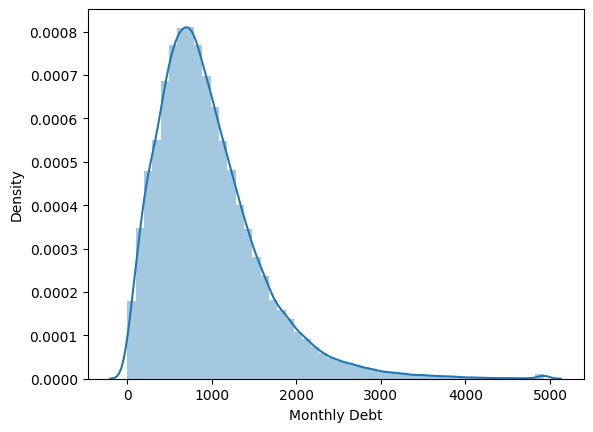

In [48]:
#Need to replace this
data.loc[data['Monthly Debt'] > 4926, 'Monthly Debt'] = 4926

sns.distplot(data["Monthly Debt"])

<Axes: xlabel='Years of Credit History', ylabel='Density'>

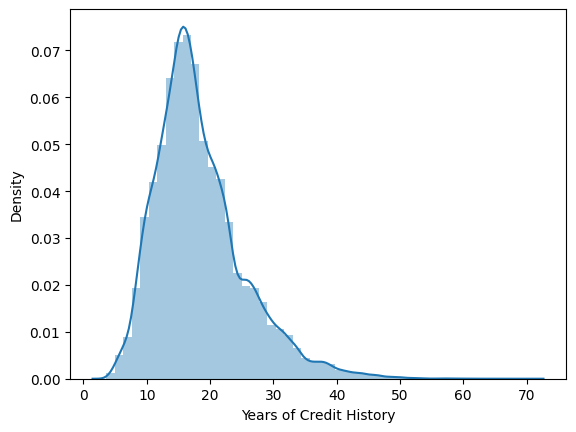

In [49]:
####################Years of credit history #################

data['Years of Credit History'].value_counts()


sns.distplot(data["Years of Credit History"])


In [50]:
#############Months since last delinquent####################

data['Months since last delinquent'].describe()


,Months since last delinquent
count,40404.000000
mean,35.080289
std,22.008583
min,0.000000
25%,16.000000
50%,32.000000
75%,51.000000
max,176.000000


In [51]:
#Lets check if there are any NA's
data['Months since last delinquent'].isna().sum()


48506

In [52]:
##############Number of open accounts ##############

data['Number of Open Accounts'].describe()


,Number of Open Accounts
count,88910.000000
mean,11.110348
std,4.978461
min,0.000000
25%,8.000000
50%,10.000000
75%,14.000000
max,76.000000


<Axes: xlabel='Number of Open Accounts', ylabel='Density'>

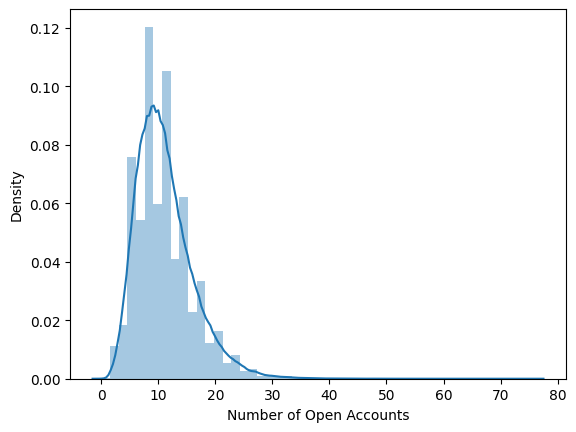

In [53]:
sns.distplot(data['Number of Open Accounts'])


In [54]:
data['Number of Open Accounts'].quantile([0.75,0.999,1])
#Replacing anything greater than 99th percentile with 99th percentile values


,Number of Open Accounts
0.750,14.0
0.999,36.0
1.000,76.0


<Axes: xlabel='Number of Open Accounts', ylabel='Density'>

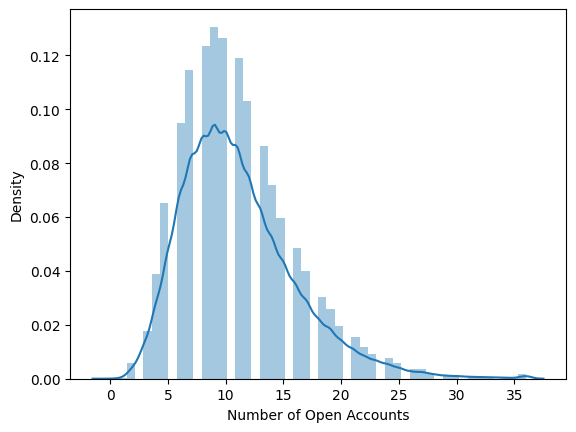

In [55]:
data.loc[data['Number of Open Accounts'] > 36, 'Number of Open Accounts'] = 36


sns.distplot(data['Number of Open Accounts'])


<Axes: xlabel='Number of Credit Problems', ylabel='Density'>

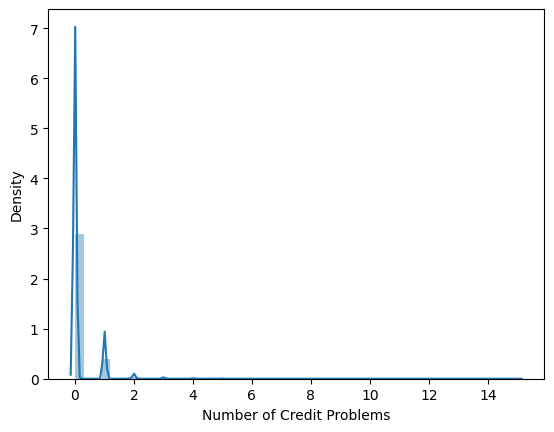

In [56]:

#######################Number of Credit problems##############

data['Number of Credit Problems'].describe()
#Max looks a bit higher.

sns.distplot(data['Number of Credit Problems'])


In [57]:

data['Number of Credit Problems'].value_counts()


,Number of Credit Problems
0,77057
1,10271
2,1092
3,311
4,101
5,46
6,14
7,6
9,4
10,3


<Axes: xlabel='Current Credit Balance', ylabel='Density'>

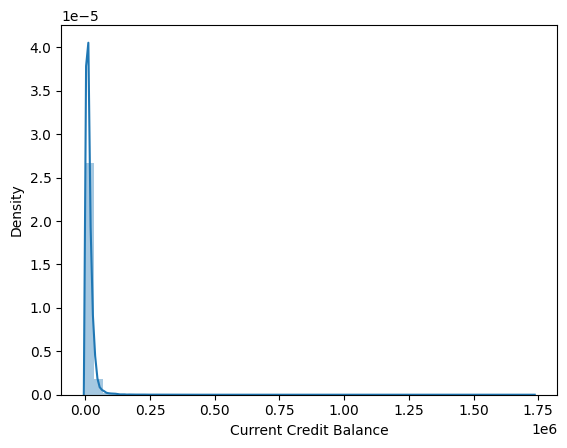

In [58]:
##################Current Credit Balance###########

data['Current Credit Balance'].describe()

sns.distplot(data['Current Credit Balance'])
#There are outliers in this data.


In [59]:
data['Current Credit Balance'].quantile([0.75,0.95,0.999,1])


,Current Credit Balance
0.750,19301.000
0.950,39933.300
0.999,227670.033
1.000,1730472.000


In [60]:

data['Current Credit Balance'].quantile([0.95,0.96,0.97,0.98,0.99,1])


,Current Credit Balance
0.95,39933.30
0.96,43501.20
0.97,48507.73
0.98,57938.12
0.99,81007.19
1.00,1730472.00


In [61]:
#Replace it with 95th percentile

data['Current Credit Balance'].quantile([0.55,0.76,0.87,0.98,0.99,1])


,Current Credit Balance
0.55,12295.00
0.76,19805.84
0.87,27525.66
0.98,57938.12
0.99,81007.19
1.00,1730472.00


<Axes: xlabel='Current Credit Balance', ylabel='Density'>

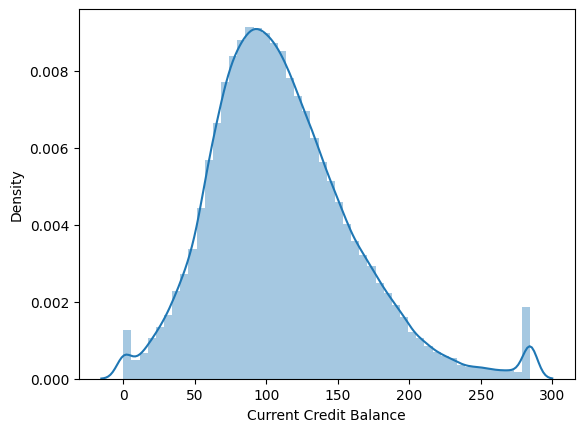

In [62]:
data.loc[data['Current Credit Balance'] > 81007, 'Current Credit Balance'] = 81007


sns.distplot(data['Current Credit Balance']**(1/2))
#The plot doesnt look good. Need to transform it


In [63]:
data['Current Credit Balance']=data['Current Credit Balance']**(1/2)


In [64]:
#######################Max open credit################

data['Maximum Open Credit'].describe()


,Maximum Open Credit
count,88910
unique,58216
top,0
freq,450


In [65]:
data['Maximum Open Credit'].value_counts()


,Maximum Open Credit
0,450
0,160
15847,9
17464,9
6827,8
...,...
28296,1
10199,1
132602,1
10395,1


In [68]:
#Replacing #value with Nan
data['Maximum Open Credit']=data['Maximum Open Credit'].replace('#VALUE!', np.nan, regex=True)


In [69]:
data['Maximum Open Credit']=pd.to_numeric(data['Maximum Open Credit'])


In [70]:
data['Maximum Open Credit'].isnull().sum()
#Replacing 2 NANs with mean


2

In [71]:
data['Maximum Open Credit']=data['Maximum Open Credit'].fillna(35965)


In [72]:
data['Maximum Open Credit'].quantile([0.55,0.76,0.87,0.98,0.99,1])



,Maximum Open Credit
0.55,24037.95
0.76,37259.84
0.87,50736.66
0.98,114682.56
0.99,171423.91
1.00,69988086.00


In [73]:
#Replacing the outliers
data.loc[data['Maximum Open Credit'] > 171423, 'Maximum Open Credit'] = 171423


In [74]:
###############Bankruptcies##########
data['Bankruptcies'].describe()


,Bankruptcies
count,88718.000000
mean,0.112672
std,0.343300
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,7.000000


In [75]:
data['Bankruptcies'].value_counts()


,Bankruptcies
0.0,79323
1.0,8936
2.0,353
3.0,80
4.0,19
5.0,5
7.0,1
6.0,1


In [76]:
data['Bankruptcies'].unique()

#So we have Nan's. Lets fill them with median


array([ 0.,  1., nan,  2.,  4.,  3.,  5.,  7.,  6.])

In [77]:
data['Bankruptcies']=data['Bankruptcies'].fillna(3)


In [78]:
####Tax Liens######

data['Tax Liens'].describe()


,Tax Liens
count,88902.000000
mean,0.028222
std,0.257533
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,15.000000


In [79]:
data['Tax Liens'].value_counts()



,Tax Liens
0.0,87274
1.0,1132
2.0,305
3.0,99
4.0,52
5.0,17
6.0,9
7.0,5
9.0,4
8.0,2


In [80]:
data['Bankruptcies'].unique()

array([0., 1., 3., 2., 4., 5., 7., 6.])

In [81]:
cat_cols = ['Term','Years in current job','Home Ownership','Purpose']

for c in cat_cols:
    data[c] = pd.factorize(data[c])[0]

In [82]:
#Imputing missing data with soft impute
updated_data=pd.DataFrame(data=SoftImpute().fit_transform(data[data.columns[3:19]],), columns=data[data.columns[3:19]].columns, index=data.index)
#Getting the dataset ready pd.get dummies function for dropping the dummy variables
df_LC = pd.get_dummies(updated_data, drop_first=True)

[SoftImpute] Max Singular Value of X_init = 23092221.868378
[SoftImpute] Iter 1: observed MAE=261.480152 rank=3
[SoftImpute] Iter 2: observed MAE=258.548469 rank=3
[SoftImpute] Iter 3: observed MAE=258.207662 rank=3
[SoftImpute] Iter 4: observed MAE=258.184852 rank=3
[SoftImpute] Iter 5: observed MAE=258.204643 rank=3
[SoftImpute] Iter 6: observed MAE=258.230069 rank=3
[SoftImpute] Iter 7: observed MAE=258.255573 rank=3
[SoftImpute] Iter 8: observed MAE=258.280106 rank=3
[SoftImpute] Iter 9: observed MAE=258.303449 rank=3
[SoftImpute] Iter 10: observed MAE=258.325504 rank=3
[SoftImpute] Iter 11: observed MAE=258.346214 rank=3
[SoftImpute] Iter 12: observed MAE=258.365509 rank=3
[SoftImpute] Iter 13: observed MAE=258.383517 rank=3
[SoftImpute] Iter 14: observed MAE=258.400220 rank=3
[SoftImpute] Iter 15: observed MAE=258.415645 rank=3
[SoftImpute] Iter 16: observed MAE=258.429899 rank=3
[SoftImpute] Iter 17: observed MAE=258.443135 rank=3
[SoftImpute] Iter 18: observed MAE=258.455321 ra

In [83]:

#Binarizing the Target variable
lb_style = LabelBinarizer()
lb_results = lb_style.fit_transform(data['Loan Status'])
y=lb_results
y=y.ravel()


#Scaling the independent variables
X_scaled = preprocessing.scale(df_LC)
print(X_scaled)
print('   ')
print(X_scaled.shape)


[[-0.1869176  -0.57302977  0.06886311 ... -0.79845518 -0.32295035
  -0.10958408]
 [ 1.48349848  1.74511004  0.26644983 ...  1.83825771 -0.32295035
  -0.10958408]
 [ 0.32079375 -0.57302977 -0.08920626 ... -0.53977375  2.39304617
  -0.10958408]
 ...
 [ 1.40247376 -0.57302977  0.78017528 ...  0.91232955 -0.32295035
  -0.10958408]
 [-1.1281112  -0.57302977 -0.16824094 ... -0.4039368  -0.32295035
  -0.10958408]
 [ 0.62515919 -0.57302977 -0.32631031 ... -0.30218149 -0.32295035
   3.77361205]]
   
(88910, 16)


In [84]:
#######Looking at other models using different classifiers
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=22)

Accuracy:  0.7276646796385858
Area under the ROC curve:  0.7437786371367399
F-metric:  0.38419803323160395
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.90      0.83     18981
           1       0.55      0.29      0.38      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.60      0.60     26673
weighted avg       0.70      0.73      0.70     26673

 
Evaluation by cross-validation:
[0.73088046 0.73762853 0.73150157 0.73150157 0.72740419]
[0.15770203 0.25137326 0.16299245 0.02831689 0.04490009 0.04055737
 0.03080421 0.03046158 0.02761248 0.02706706 0.02785725 0.02524857
 0.03073877 0.03578309 0.03659303 0.04199181]


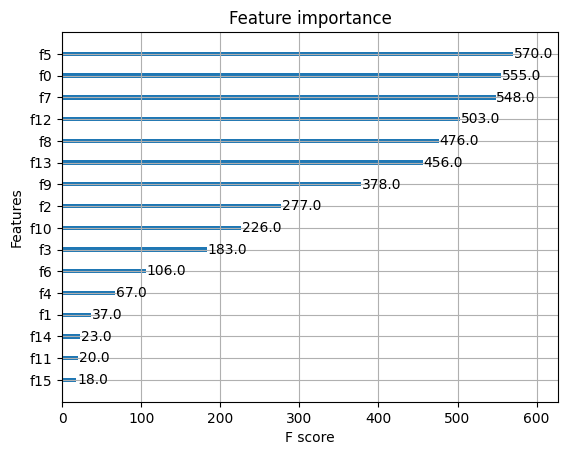

In [85]:
#Finding accuracy and feature importance using XGB classifier
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(), X_train, y_train,X_test,y_test)
print(xgb0.feature_importances_)
plot_importance(xgb0)
pyplot.show()
feat1 = feat_importance(xgb0)


In [86]:
xgb0, y_pred_b, y_pred2_b = classify(XGBClassifier(n_estimators=47, learning_rate=0.015), X_train, y_train,X_test,y_test)

Accuracy:  0.7290893412814456
Area under the ROC curve:  0.7381636980878846
F-metric:  0.3349898766795509
 
Classification report:
              precision    recall  f1-score   support

           0       0.75      0.93      0.83     18981
           1       0.57      0.24      0.33      7692

    accuracy                           0.73     26673
   macro avg       0.66      0.58      0.58     26673
weighted avg       0.70      0.73      0.69     26673

 
Evaluation by cross-validation:
[0.73666452 0.74116324 0.73608098 0.73664337 0.73013578]


In [87]:
#######K nearest Neighbour classifier ################

knc, y_p, y_p2 = classify(KNeighborsClassifier(), X_train, y_train,X_test,y_test)


Accuracy:  0.6839500618603082
Area under the ROC curve:  0.6073078340129547
F-metric:  0.30992141453831046
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.86      0.80     18981
           1       0.42      0.25      0.31      7692

    accuracy                           0.68     26673
   macro avg       0.58      0.55      0.55     26673
weighted avg       0.65      0.68      0.66     26673

 
Evaluation by cross-validation:
[0.69368573 0.69705977 0.69783884 0.69141159 0.68747489]


In [88]:
########Logistic Regression ##############
logit, y_p, y_p2 = classify(LogisticRegression(), X_train, y_train,X_test,y_test)

Accuracy:  0.7201289693697747
Area under the ROC curve:  0.6722709585903062
F-metric:  0.21213720316622697
 
Classification report:
              precision    recall  f1-score   support

           0       0.73      0.96      0.83     18981
           1       0.56      0.13      0.21      7692

    accuracy                           0.72     26673
   macro avg       0.65      0.54      0.52     26673
weighted avg       0.68      0.72      0.65     26673

 
Evaluation by cross-validation:
[0.72606041 0.72919344 0.72812726 0.7282076  0.72684181]


In [89]:
########Decision Tree Classifier ##########
dtc, y_p, y_p2 = classify(DecisionTreeClassifier(), X_train, y_train,X_test,y_test)

Accuracy:  0.6532073632512279
Area under the ROC curve:  0.5801595277024294
F-metric:  0.40399484536082475
 
Classification report:
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     18981
           1       0.40      0.41      0.40      7692

    accuracy                           0.65     26673
   macro avg       0.58      0.58      0.58     26673
weighted avg       0.66      0.65      0.65     26673

 
Evaluation by cross-validation:
[0.65560733 0.65641067 0.65903431 0.65774886 0.65212501]


computing GradientBoosting - Non-balanced 
computing LogisticRegression - Non-balanced 
computing RandomForestClassifier - Non-balanced 
computing XGBClassifier - Non-balanced 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.245771,0.752879,0.577406,0.254512,0.353296,Non-balanced
1,LogisticRegression,0.158180,0.672405,0.554031,0.127651,0.207495,Non-balanced
2,RandomForestClassifier,0.181900,0.696580,0.490308,0.236596,0.319175,Non-balanced
3,XGBClassifier,0.245700,0.743843,0.547578,0.290344,0.379477,Non-balanced


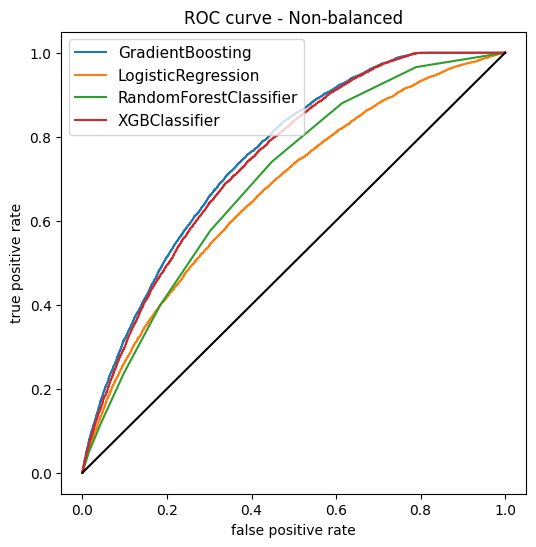

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)
models_report, conf_matrix = run_models(X_train, y_train, X_test, y_test, model_type = 'Non-balanced')
models_report

computing GradientBoosting - Balanced 
computing LogisticRegression - Balanced 
computing RandomForestClassifier - Balanced 
computing XGBClassifier - Balanced 


,model,matthews_corrcoef,roc_auc_score,precision_score,recall_score,f1_score,model_type
0,GradientBoosting,0.185946,0.675188,0.326013,0.908084,0.479779,Balanced
1,LogisticRegression,0.242569,0.681430,0.427408,0.547750,0.480154,Balanced
2,RandomForestClassifier,0.155118,0.620802,0.331094,0.789008,0.466450,Balanced
3,XGBClassifier,0.199309,0.671545,0.341809,0.841577,0.486162,Balanced


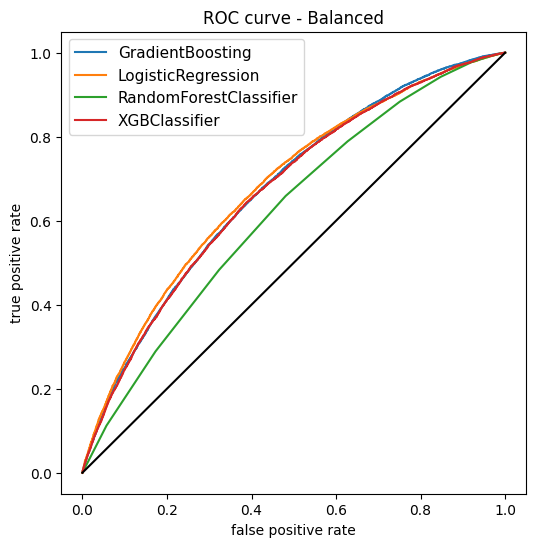

In [91]:
###########Synthetically balancing the dataset##################
index_split = int(len(X_scaled)/2)
X_train, y_train = SMOTE().fit_resample(X_scaled[0:index_split, :], y[0:index_split])
X_test, y_test = X_scaled[index_split:], y[index_split:]
models_report_bal, conf_matrix_bal = run_models(X_train, y_train, X_test, y_test, model_type = 'Balanced')
models_report_bal

Gradient Boosting is a good choice for the loan eligibility problem because it has the highest recall (0.908), ensuring that most eligible applicants are correctly identified. It also balances precision and recall well with a reasonable F1 score (0.48), making it suitable for complex loan data where identifying eligible applicants is a priority without overly sacrificing precision.

In [93]:
################GBM model performed the best
# save model
gbm=GradientBoostingClassifier(max_depth= 6, n_estimators=100, max_features = 0.3)
gbm.fit(X_scaled, y)
joblib.dump(gbm, 'GBM_Model_version1.pkl')

['GBM_Model_version1.pkl']